## Setup & Data

In [2]:
# Import pytorch
import torch
from torch import nn

# Import torch vision
import torchvision
from torchvision import transforms, datasets

# Import matplotlib for visualisation
import matplotlib.pyplot as plt

In [3]:
# Define augmentation and normalisation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Normalise and transform test data
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Setup training data
train_data = datasets.CIFAR10(
    root="sample_data",
    train=True,
    download=True,
    transform=train_transform,
    target_transform=None
)

# Setup testing data
test_data = datasets.CIFAR10(
    root="sample_data",
    train=False,
    download=True,
    transform=test_transform
)

In [4]:
# Dislpay the first image and its corresponding lable from the training dataset
img, label = train_data[0]
img, label

(tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.5373,  ...,  0.2471,  0.2392,  0.2392],
          ...,
          [-1.0000, -1.0000,  0.6941,  ...,  0.1216,  0.5922,  0.6157],
          [-1.0000, -1.0000,  0.7255,  ..., -0.1059,  0.4588,  0.3569],
          [-1.0000, -1.0000,  0.6314,  ..., -0.6078,  0.0745,  0.2549]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.5137,  ...,  0.0118,  0.0196,  0.0353],
          ...,
          [-1.0000, -1.0000,  0.3647,  ..., -0.1608,  0.3098,  0.3569],
          [-1.0000, -1.0000,  0.4275,  ..., -0.3176,  0.2157,  0.1294],
          [-1.0000, -1.0000,  0.3333,  ..., -0.8118, -0.1765,  0.0431]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000,

# About the data

- Input and output shapes
- Lables
- Sample images

In [5]:
# Per-sample input shape
print(f"Per-sample input shape: {img.shape}") # [3, 32, 32] -> 3 colour channels, 32 x 32

# Output shape
print("Output shape: {label}") # scalar integer

Per-sample input shape: torch.Size([3, 32, 32])
Output shape: {label}


In [6]:
# Number of samples
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(50000, 50000, 10000, 10000)

In [7]:
# Class names
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7254902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.70980394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.4901961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.85882354].
Clipping input data to

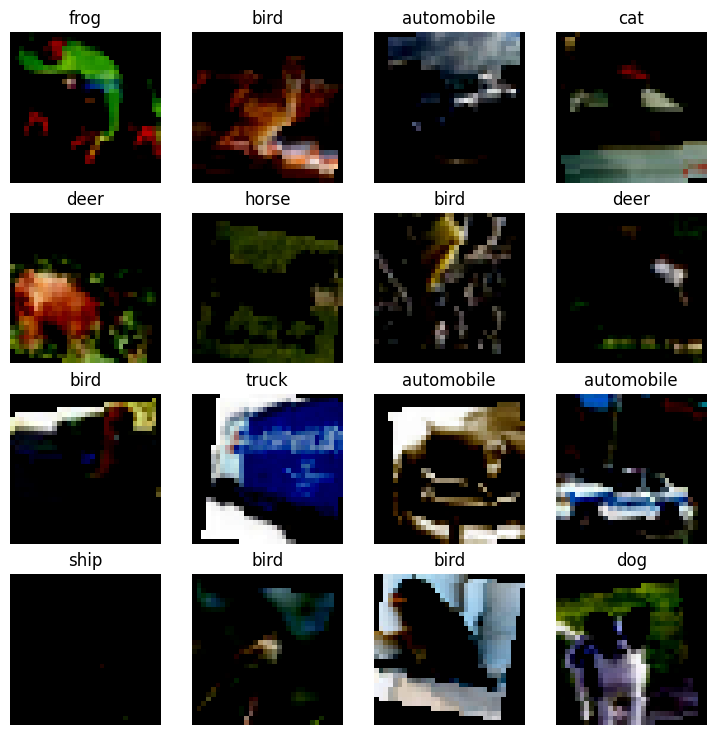

In [8]:
# Plot some more images
torch.manual_seed(42)

fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item() # get a random sample from train_data
    image, label = train_data[random_idx]

    # Disaply each sample
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis(False)


# Prepare dataloader

- Create batches of samples from train_data and test_data


In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Turn datasets into batches
train_dataloader = DataLoader(
    train_data, # dataset to turn into batches
    batch_size=BATCH_SIZE, # number of samples per batch
    shuffle=True # shuffle data per epoch -> improved generalisation
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Display batch sizes
print(f"Train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Train dataloader: 1563 batches of 32
Test dataloader: 313 batches of 32


# Model 0: Simple CNN

In [30]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.group1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.group2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 8 * 8,
                      out_features=hidden_units*4),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units*4,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.group1(x)
        x = self.group2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model_0 = SimpleCNN(input_shape=3,  # Images have 3 color channels
                    hidden_units=32,
                    output_shape=len(class_names))
model_0

SimpleCNN(
  (group1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (group2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

# Model 1: Complex CNN


In [31]:
class ComplexCNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        # Convolutional layers with batch normalisation and max pooling
        self.group_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(num_features=hidden_units), # normalise activations of a layer at each batch -> improved training speed and stability
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
            )

        self.group_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.group_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        # Fully connected layers (Classifier)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units* 4 * 4, 
                      hidden_units*4),
            nn.ReLU(),
            nn.Dropout(p=0.5), # randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution -> prevent overfitting
            nn.Linear(hidden_units*4,
                      output_shape)
            )
    
    def forward(self, x: torch.Tensor):
        x = self.group_1(x)
        x = self.group_2(x)
        x = self.group_3(x)
        x = self.classifier(x)
        return x


torch.manual_seed(42)
model_1 = ComplexCNN(input_shape=3,
                    hidden_units=32,
                    output_shape=len(class_names))
model_1


ComplexCNN(
  (group_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (group_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (group_3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_fea

# Model 2: Pretrained / Loaded CNN

In [48]:
from torchvision import models

model_2 = models.resnet18(pretrained=True) # download pretrained weights

model_2.conv1 = nn.Conv2d(in_channels=3,
                        out_channels=64,
                        kernel_size=3,
                        stride=1,
                        padding=1,
                        bias=False)
                        
model_2.maxpool = nn.Identity() # remove maxpool layer for small images

model_2.fc = nn.Linear(model_2.fc.in_features,
                       len(class_names)) # change output layer to match number of classes

model_2

c:\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

# Train the models

### Setup evaluation metric

In [32]:
import torchmetrics
from torchmetrics import Accuracy

# Initialise accuracy metrics
train_metric = Accuracy(task="multiclass", num_classes=len(class_names))
test_metric = Accuracy(task="multiclass", num_classes=len(class_names))


### Functionise train and test loops

In [33]:
def train_loop(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               metric: torchmetrics.Accuracy):

    train_loss = 0
    metric.reset()
    for batch, (X, y) in enumerate(data_loader):
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss and update accuracy metric
        loss = loss_fn(y_pred, y)
        train_loss += loss

        metric.update(y_pred, y)

        # 3. Optimiser zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimiser step
        optimizer.step()

    # Calculate loss and accuracy per epoch
    train_loss = (train_loss / len(data_loader)).item()
    train_acc = metric.compute().item() * 100 # to percentage
    metric.reset() # reset for next epoch
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

    return train_loss, train_acc


def test_loop(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              metric: torchmetrics.Accuracy):
    test_loss = 0

    # Turn on evaluation
    model.eval()
    metric.reset()

    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and update accuracy metric
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            metric.update(test_pred, y)

        # Adjust metrics and print out
        test_loss = (test_loss / len(data_loader))
        test_acc = metric.compute().item() * 100 # to percentage
        metric.reset()
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

    return test_loss, test_acc

### Setup loss function and optimizer for model 0

### Train Model 0

In [34]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=1e-3)

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

model_0_train_results = {"loss": [], "accuracy": []}
model_0_test_results = {"loss": [], "accuracy": []}

torch.manual_seed(42) # for reproducibility

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    print(f"Epoch: {epoch+1}\n-------")
    train_loss, train_acc = train_loop(model=model_0,
                                       data_loader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       metric=train_metric)

    test_loss, test_acc = test_loop(model=model_0,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    metric=test_metric)

    model_0_train_results["loss"].append(train_loss)
    model_0_train_results["accuracy"].append(train_acc)
    model_0_test_results["loss"].append(test_loss)
    model_0_test_results["accuracy"].append(test_acc)




In [36]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=1e-3)

### Train Model 1

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

model_1_train_results = {"loss": [], "accuracy": []}
model_1_test_results = {"loss": [], "accuracy": []}

torch.manual_seed(42) # for reproducibility

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    print(f"Epoch: {epoch+1}\n-------")
    train_loss, train_acc = train_loop(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               metric=train_metric)
               
    test_loss, test_acc = test_loop(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              metric=test_metric)

    model_1_train_results["loss"].append(train_loss)
    model_1_train_results["accuracy"].append(train_acc)
    model_1_test_results["loss"].append(test_loss)
    model_1_test_results["accuracy"].append(test_acc)

### Train Model 2

In [50]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.fc.parameters(), lr=1e-3)

In [53]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

model_2_train_results = {"loss": [], "accuracy": []}
model_2_test_results = {"loss": [], "accuracy": []}

torch.manual_seed(42) # for reproducibility

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    print(f"Epoch: {epoch+1}\n-------")
    train_loss, test_loss = train_loop(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               metric=train_metric)

    test_loop(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              metric=test_metric)

    model_2_train_results["loss"].append(train_loss)
    model_2_train_results["accuracy"].append(train_acc)
    model_2_test_results["loss"].append(test_loss)
    model_2_test_results["accuracy"].append(test_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
-------
Train loss: 1.77488 | Train acc: 37.00%


 10%|█         | 1/10 [19:07<2:52:05, 1147.22s/it]

Test loss: 1.68070 | Test accuracy: 39.65%

Epoch: 2
-------
Train loss: 1.62388 | Train acc: 42.69%


 20%|██        | 2/10 [38:14<2:32:58, 1147.36s/it]

Test loss: 1.57467 | Test accuracy: 44.83%

Epoch: 3
-------
Train loss: 1.58246 | Train acc: 43.95%


 30%|███       | 3/10 [57:13<2:13:25, 1143.64s/it]

Test loss: 1.54958 | Test accuracy: 45.82%

Epoch: 4
-------
Train loss: 1.56075 | Train acc: 44.56%


 40%|████      | 4/10 [1:16:19<1:54:27, 1144.51s/it]

Test loss: 1.55799 | Test accuracy: 45.94%

Epoch: 5
-------
Train loss: 1.54407 | Train acc: 45.41%


 50%|█████     | 5/10 [1:35:15<1:35:06, 1141.32s/it]

Test loss: 1.50184 | Test accuracy: 47.63%

Epoch: 6
-------
Train loss: 1.53957 | Train acc: 45.93%


 60%|██████    | 6/10 [1:54:25<1:16:17, 1144.44s/it]

Test loss: 1.52486 | Test accuracy: 46.64%

Epoch: 7
-------
Train loss: 1.53424 | Train acc: 45.60%


 70%|███████   | 7/10 [2:14:45<58:27, 1169.02s/it]  

Test loss: 1.51899 | Test accuracy: 47.29%

Epoch: 8
-------
Train loss: 1.52393 | Train acc: 45.98%


 80%|████████  | 8/10 [2:34:56<39:24, 1182.44s/it]

Test loss: 1.54288 | Test accuracy: 46.08%

Epoch: 9
-------
Train loss: 1.52251 | Train acc: 46.54%


 90%|█████████ | 9/10 [2:54:56<19:47, 1187.80s/it]

Test loss: 1.52939 | Test accuracy: 46.96%

Epoch: 10
-------
Train loss: 1.52156 | Train acc: 46.17%


100%|██████████| 10/10 [3:15:06<00:00, 1170.68s/it]

Test loss: 1.51295 | Test accuracy: 47.21%



# Compare results of each model

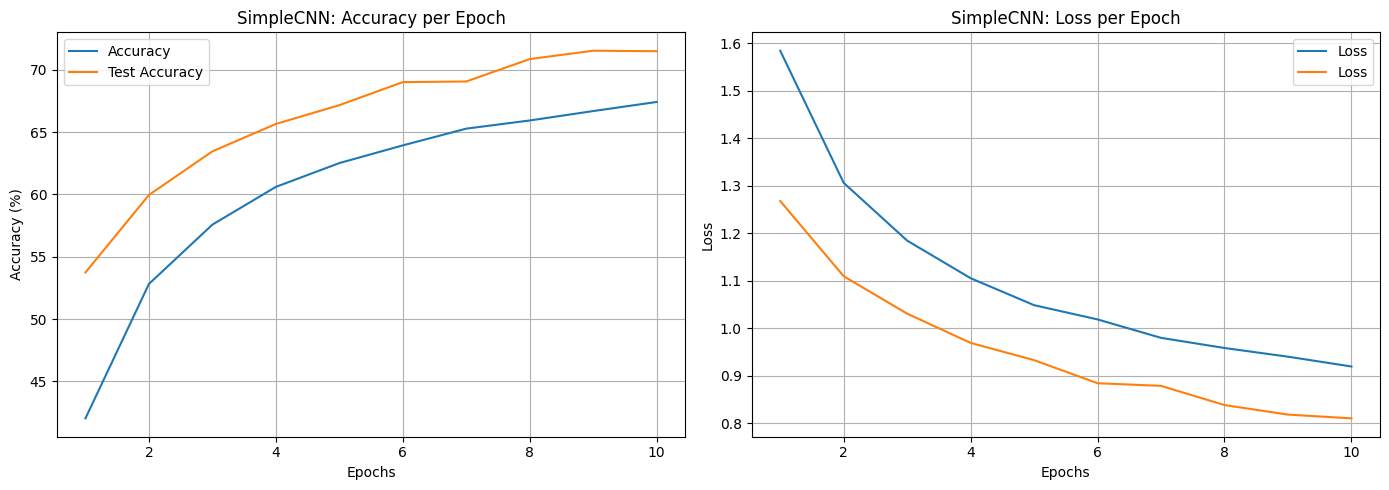

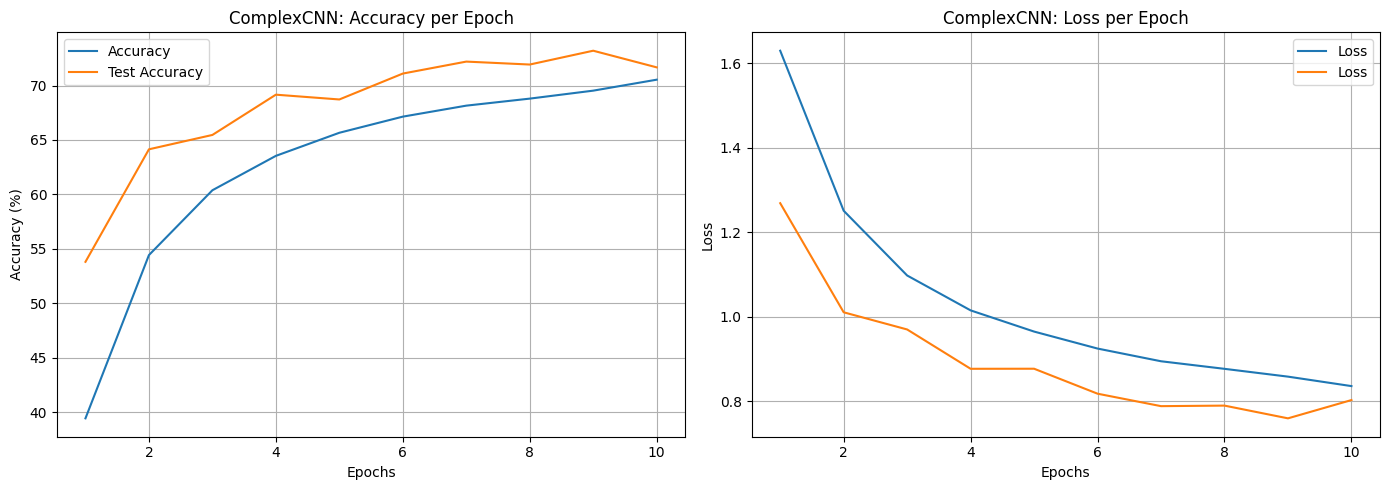

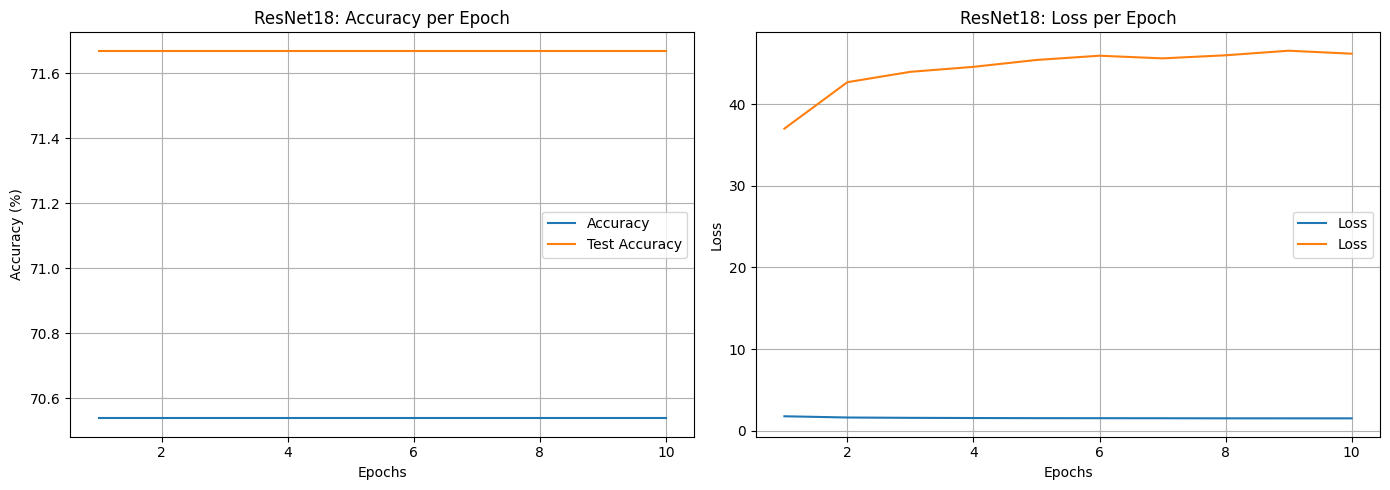

In [55]:
# Plot accuracy and loss curves
import matplotlib.pyplot as plt

model_0_results = {
    "train": model_0_train_results,
    "test": model_0_test_results
}

model_1_results = {
    "train": model_1_train_results,
    "test": model_1_test_results
}

model_2_results = {
    "train": model_2_train_results,
    "test": model_2_test_results
}

# Dictionary of models
models = {
    "SimpleCNN": model_0_results,
    "ComplexCNN": model_1_results,
    "ResNet18": model_2_results
}

for model_name, results in models.items():
    epochs = range(1, len(results["train"]["loss"]) + 1)

    # Plot a figure for each model with two subplots for accuracy and loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ## Accuracy subplot
    ax1.plot(epochs, results["train"]["accuracy"], label="Accuracy")
    ax1.plot(epochs, results["test"]["accuracy"], label="Test Accuracy")
    ax1.set_title(f"{model_name}: Accuracy per Epoch")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy (%)")
    ax1.legend()
    ax1.grid(True)

    # Loss subplot
    ax2.plot(epochs, results["train"]["loss"], label="Loss")
    ax2.plot(epochs, results["test"]["loss"], label="Loss")
    ax2.set_title(f"{model_name}: Loss per Epoch")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()